In [1]:
from ThesisPackage.Environments.multi_pong_sender_receiver_ball_onehot import PongEnvSenderReceiverBallOneHot
from ThesisPackage.RL.Centralized_PPO.multi_ppo import PPO_Multi_Agent_Centralized
from ThesisPackage.RL.Decentralized_PPO.util import flatten_list, reverse_flatten_list_with_agent_list
from ThesisPackage.Wrappers.vecWrapper import PettingZooVectorizationParallelWrapper
import torch
import numpy as np
import time
import os
import matplotlib.pyplot as plt
import torch.nn.functional as F

In [2]:
def make_env(sequence_length = 1):
    vocab_size = 3
    max_episode_steps = 512
    env = PongEnvSenderReceiverBallOneHot(width=20, height=20, vocab_size=vocab_size, sequence_length=sequence_length, max_episode_steps=max_episode_steps)
    # env = ParallelFrameStack(env, 4)
    return env

In [3]:
def load(path="models/checkpoints", sequence_length=1):
    env = make_env(sequence_length)
    models = {}
    for model in os.listdir(path):
        if f"multi_pong_{sequence_length}" in model:
            state_dict = torch.load(os.path.join(path, model))
            timestamp = model.split("_")[-1]
            timestamp = int(timestamp.split(".")[0])
            agent = PPO_Multi_Agent_Centralized(env, device="cpu")
            agent.agent.load_state_dict(state_dict)
            models[timestamp] = agent
    return models

In [4]:
num_steps = 10000
models = {}
for i in [1, 2, 3]:
    agents = load("/Users/cowolff/Documents/GitHub/ma.pong_rl/models/checkpoints", sequence_length=i)
    models[i] = agents
agent_indizes = list(agents.keys())
agent_indizes.sort()

/Users/cowolff/miniconda3/envs/thesis/lib/python3.10/site-packages/gym/spaces/box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float16
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


In [5]:
def test(agent, env, timesteps=1024, tracking_agent="paddle_1"):
    saliencies = []
    full_saliences = []
    obs, info = env.reset()
    state = env.state()
    average_length = []
    tokens = []
    for timestep in range(timesteps):
            
        traking_index = env.agents.index(tracking_agent)
        tokens.append(obs[tracking_agent][-1 * env.sequence_length * env.vocab_size:])
        obs = [obs]
        state = [state]
        obs = np.array(flatten_list(obs))
        state = np.array(flatten_list(state))

        obs_track = torch.tensor(np.expand_dims(obs[traking_index], axis=0), dtype=torch.float32, requires_grad=True)
        logits = agent.agent.actor(obs_track)

        agent.agent.actor.zero_grad()

        grad_tensor = torch.zeros_like(logits)
        grad_tensor[:, :-1 * env.sequence_length * env.vocab_size] = 1

        logits.backward(grad_tensor)

        saliency = obs_track.grad.data.abs()

        saliency = saliency.numpy()
        saliency = (saliency - saliency.min()) / (saliency.max() - saliency.min())

        importances = []
        # for i in range(1, env.sequence_length + 1):
        #     if i == 1:
        #         end_token = -1
        #     else:
        #         end_token = -1 * (i - 1) * env.vocab_size
        #     cur_language = np.max(saliency[:, -1 * i * env.vocab_size:end_token])
        #     importances.append(cur_language)
        
        importances = np.max(saliency[:, -1 * env.sequence_length * env.vocab_size:], axis=1)

        # importances = np.array(importances)
        # mean_language = np.mean(saliency[:, -1 * env.sequence_length * env.vocab_size:], dtype=np.float32)
        # maximum_language = max(importances)

        obs = torch.tensor(obs, dtype=torch.float32)
        state = torch.tensor(state, dtype=torch.float32)
        with torch.no_grad():
            actions, _, _, _ = agent.agent.get_action_and_value(obs, state)
            actions = reverse_flatten_list_with_agent_list(actions, agent.agents)

        actions = actions[0]
        actions = {agent: action.cpu().numpy() for agent, action in actions.items()}

        saliencies.append(importances)
        full_saliences.append(saliency)

        obs, _, truncations, terminations, infos = env.step(actions)
        state = env.state()

        if any([truncations[agent] or terminations[agent] for agent in env.agents]):
            average_length.append(timestep)
            obs, info = env.reset()
    full_saliences = np.stack(full_saliences, axis=0)
    saliencies = np.array(saliencies)
    return saliencies, average_length, full_saliences, np.array(tokens)

In [6]:
import matplotlib.lines as mlines
import matplotlib.pyplot as plt

def plot_saliencies(full_saliencies, path=None, title="Heatmap for one epoch"):
    # Transposing the reshaped data for desired orientation
    data_reshaped = full_saliencies.reshape(-1, full_saliencies.shape[2])
    data_transposed = data_reshaped.T

    # Plotting the heatmap with the new orientation
    plt.figure(figsize=(25, 5))
    plt.imshow(data_transposed, aspect='auto', cmap='viridis')
    plt.colorbar(label='Values')
    plt.title(title)
    plt.xlabel('Timestep')
    plt.ylabel('Features')

    red_line = mlines.Line2D([], [], color='red', label='Language Channel')

    # Adding a red box around the last two features (4 and 5)
    rect = plt.Rectangle((-0.1, 9.5), data_reshaped.shape[0] - 0.9, 1.99, linewidth=2, edgecolor='red', facecolor='none')
    plt.gca().add_patch(rect)

    plt.legend(handles=[red_line])

    if path != None:
        plt.savefig(path)
    else:
        plt.show()

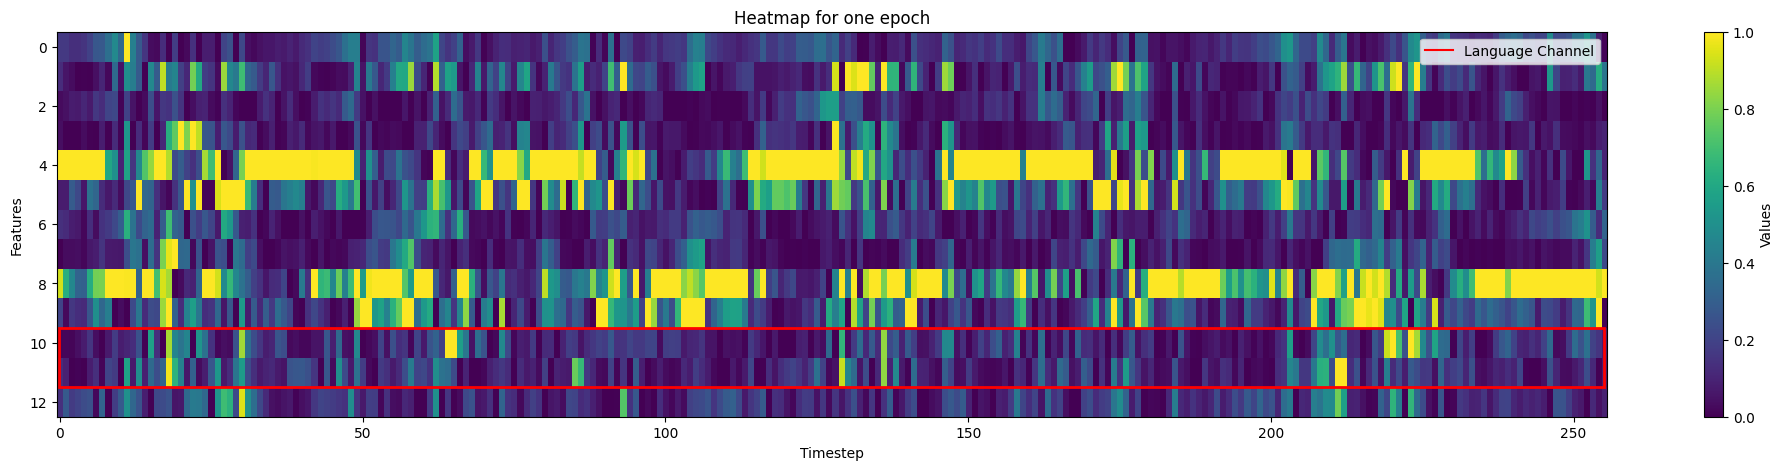

In [7]:
env = make_env(1)
saliencies, average_length, full_saliences, tokens = test(models[1][agent_indizes[-1]], env, timesteps=256)
plot_saliencies(full_saliences)

In [8]:
from tqdm import tqdm

results = {}
def calculate_tracking_saliencies(cur_agents, env):
    number_of_important_saliencies = {}

    for index, agent in tqdm(cur_agents.items(), desc="Processing agents"):
        saliencies, average_length, full_saliences, tokens = test(agent, env, timesteps=10000)
        number_of_important_saliencies[index] = np.where(saliencies > 0.8)[0].sum()

    return number_of_important_saliencies

for seq, cur_agents in models.items():
    env = make_env(seq)
    results[seq] = calculate_tracking_saliencies(cur_agents, env)

/Users/cowolff/miniconda3/envs/thesis/lib/python3.10/site-packages/gym/spaces/box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float16
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")
Processing agents: 100%|██████████| 30/30 [02:58<00:00,  5.95s/it]


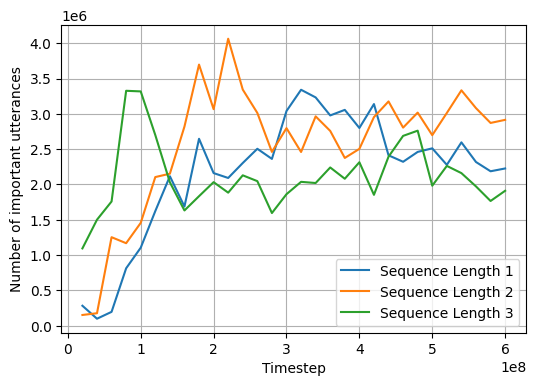

In [10]:
# Sort the dictionary by keys (indices)
# Plotting
plt.figure(figsize=(6, 4))

max_steps = 6e8

for seq, number_of_important_saliencies in results.items():
    sorted_data = dict(sorted(number_of_important_saliencies.items()))
    data_points = list(sorted_data.keys())
    data_points = [(value / max(data_points)) * max_steps for value in data_points]
    plt.plot(data_points, sorted_data.values(), label=f"Sequence Length {seq}")
plt.xlabel('Timestep')
plt.ylabel('Number of important utterances')
plt.legend()
plt.grid(True)
plt.savefig("/Users/cowolff/Documents/GitHub/ma.pong_rl/Plotting/saliencies_live/important_utterances_final_pong.pdf")